<IPython.core.display.Javascript object>


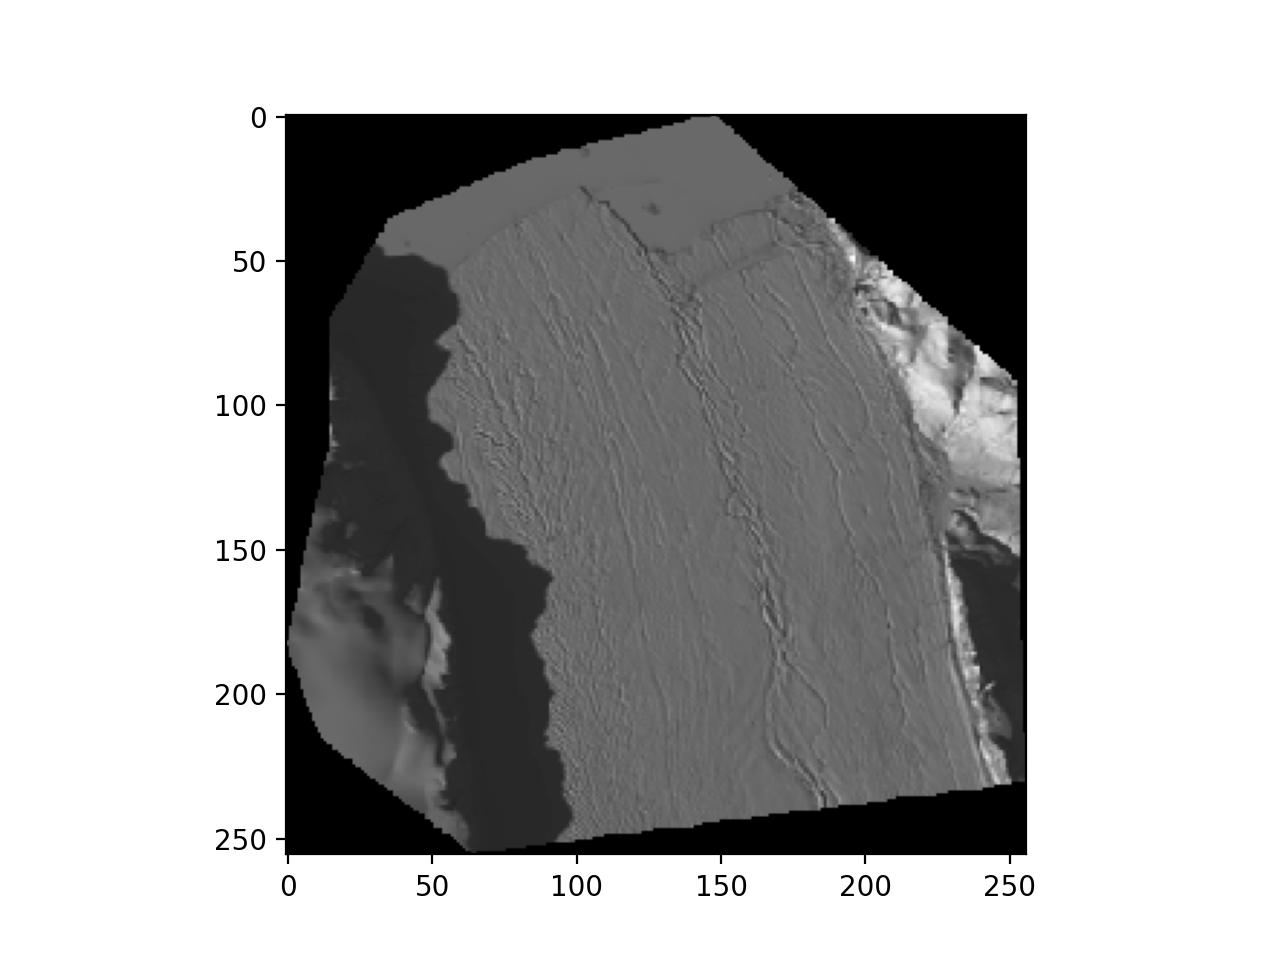

In [17]:
from osgeo import gdal,ogr,osr
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

#Cropping Geotiff to extent and reading with GDAL

filen=['LC08_L1TP_030247_20150420_20170228_01_T1_B5.TIF']
ProjectPath='/mnt/data/millanr1/DATA_SERVER/GREENLAND/DAMAGING/CREVASSES/CALFIN/'
DomainName='ryder'
#Clipping shapefile to domain boundaries{{{
shpDomain=ProjectPath+'/'+DomainName+'_pol.shp' #Polygon shapefile with projection PS EPSG:3413 
spacing='15'      #Grid spacing of 15 m
interp='cubic'    #Cubic interpolation when cropping, not really used since spacing is same as input res
gdalwarp='gdalwarp'
subsetsizex='256' #Subset size used as in the CALFIN paper
subsetsizey='256'
for f in filen:
    #WARNING PATH TO GDAL
    os.system(gdalwarp+' -cutline '+shpDomain+' -crop_to_cutline '+f+' -tr '+spacing+' '+spacing+' -r '+interp+' '+ProjectPath+'/'+f.split('.TIF')[0]+'_crop.tif')
    #}}}
    #Rescale to subset size{{{
    os.system(gdalwarp+' -ts '+subsetsizex+' '+subsetsizey+' '+f.split('.TIF')[0]+'_crop.tif '+' '+f.split('.TIF')[0]+'_subset.tif')
    #}}}

#reading tif file{{{
a=gdal.Open(ProjectPath+'/'+f.split('.tif')[0]+'_subset.tif')
b=a.GetRasterBand(1)
raw=b.ReadAsArray()
#}}}
#ploting{{{
plt.imshow(raw,cmap='gray')
plt.show()
#}}}

<IPython.core.display.Javascript object>


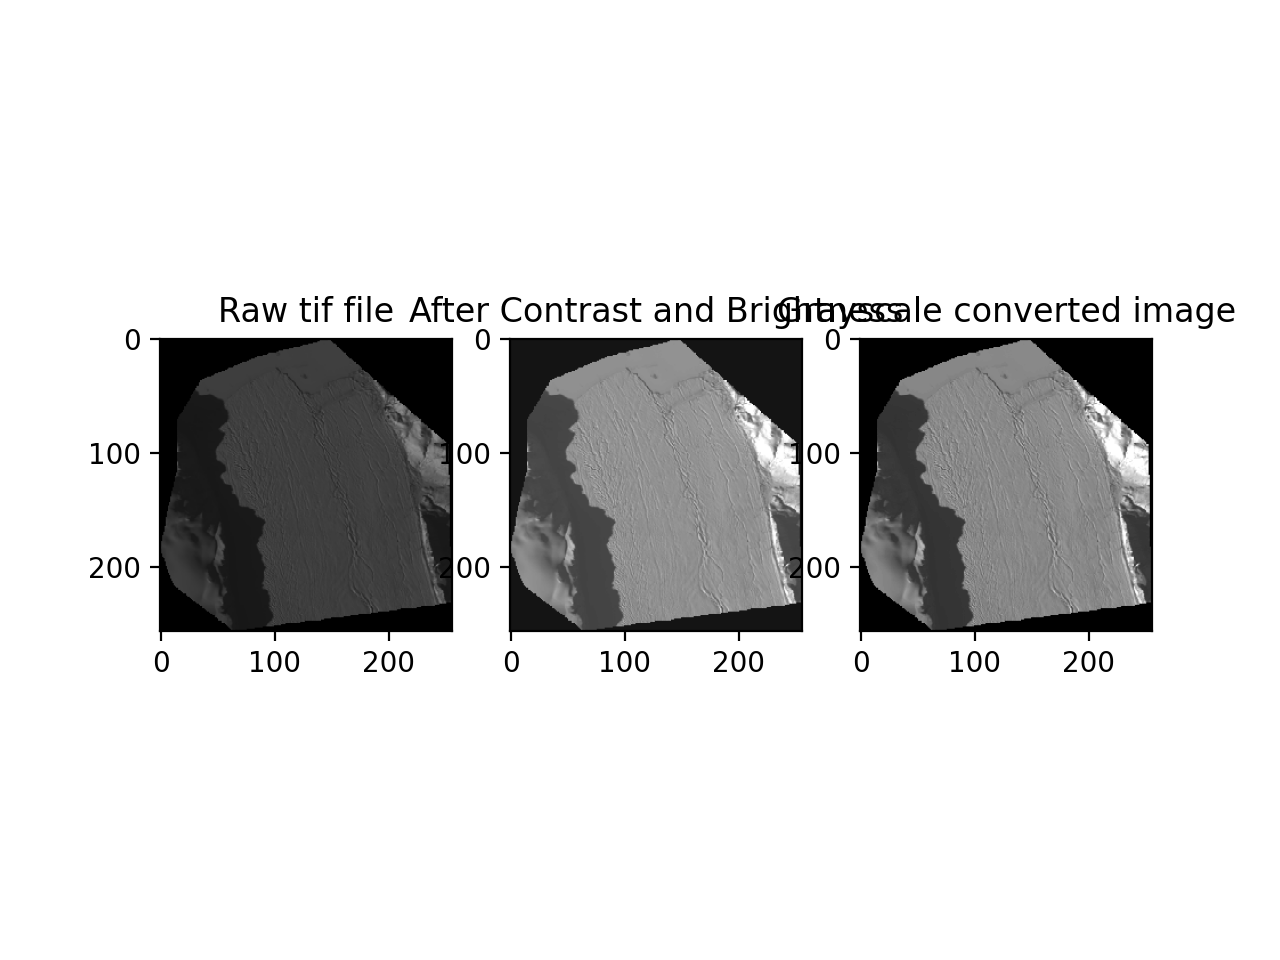

Text(0.5, 1.0, 'Grayscale converted image')

In [18]:
#Contrast and Brightness processing with OPENCV
%matplotlib notebook
import cv2 as cv

image=cv.imread('LC08_L1TP_030247_20150420_20170228_01_T1_B5_subset.tif')#open the image with opencv

alpha = 2 # Contrast control (range of 1.0-3.0)
beta = 20 # Brightness control (range of 0-100)
adjusted = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
gray_image = cv.cvtColor(adjusted, cv.COLOR_BGR2GRAY) #Convert RGB image to grayscale image

fig, (ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(image,cmap='gray'); ax1.set_title('Raw tif file')
ax2.imshow(adjusted,cmap='gray'); ax2.set_title('After Contrast and Brightness')
ax3.imshow(gray_image,cmap='gray'); ax3.set_title('Grayscale converted image')

<IPython.core.display.Javascript object>


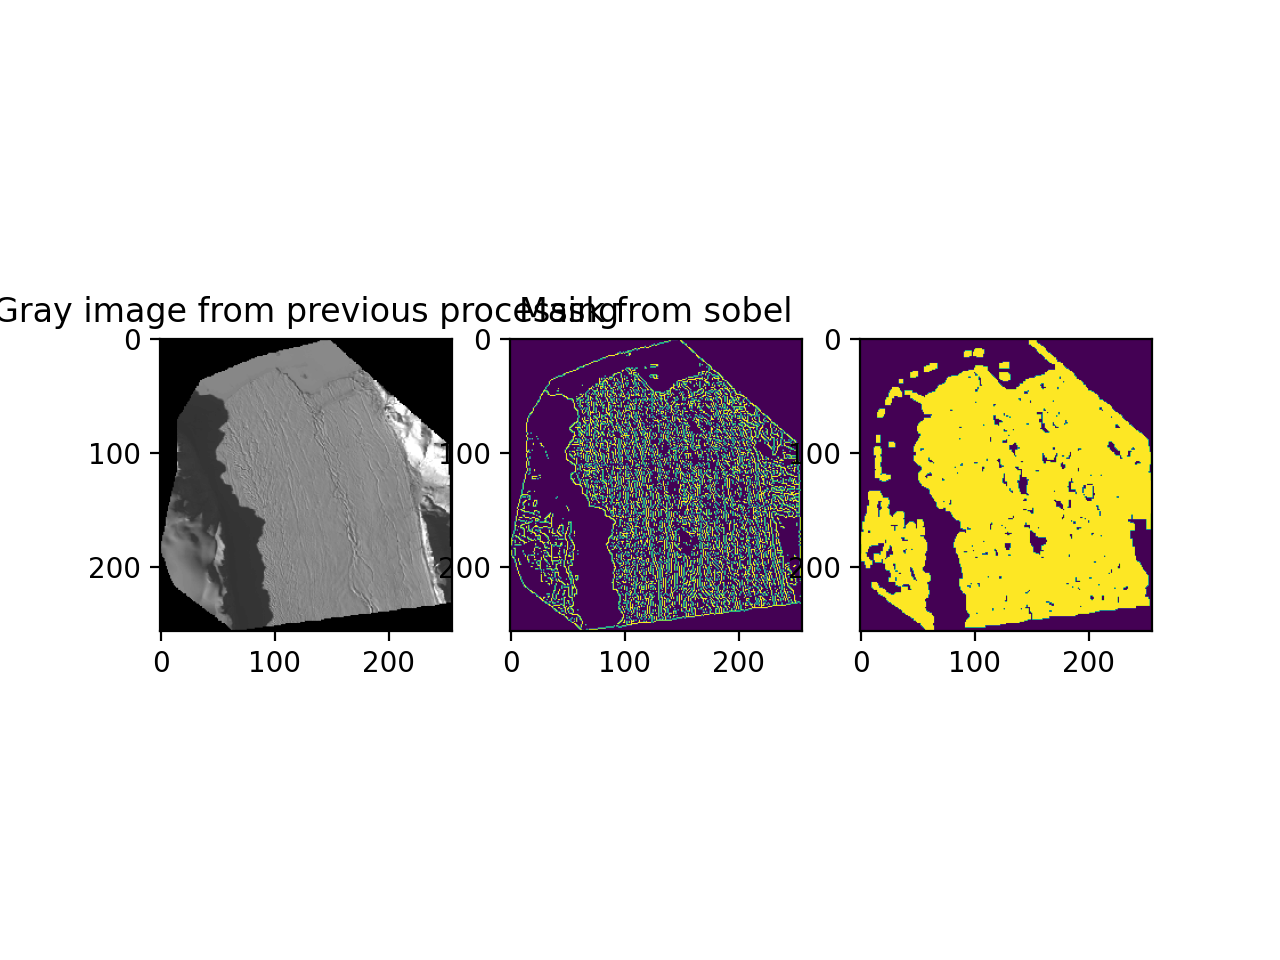

Text(0.5, 1.0, 'Mask from sobel')

In [23]:
#Basic sobel filtering
%matplotlib notebook
from scipy import ndimage
#edges=ndimage.sobel(gray_image) #Sobel using ndimage
edges=cv.Canny(gray_image,20,20) #Sobel from opencv
#La loop suivante tente de faire un petit masque en analyse la densité des contours détecté par le sobel
#C'est un essaie...
mask=np.zeros(edges.shape)

for i in range(0,edges.shape[0]):
    for j in range(0,edges.shape[1]):
        edgeloc=edges[i-2:i+2,j-2:j+2]
        l=len(edgeloc[edgeloc==255])
        if l>4:mask[i-2:i+2,j-2:j+2]=1



fig, (ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(gray_image,cmap='gray');ax1.set_title('Gray image from previous processing')
ax2.imshow(edges);ax2.set_title('Sobel filter')
ax3.imshow(mask);ax2.set_title('Mask from sobel')


(256, 256, 3)


<IPython.core.display.Javascript object>


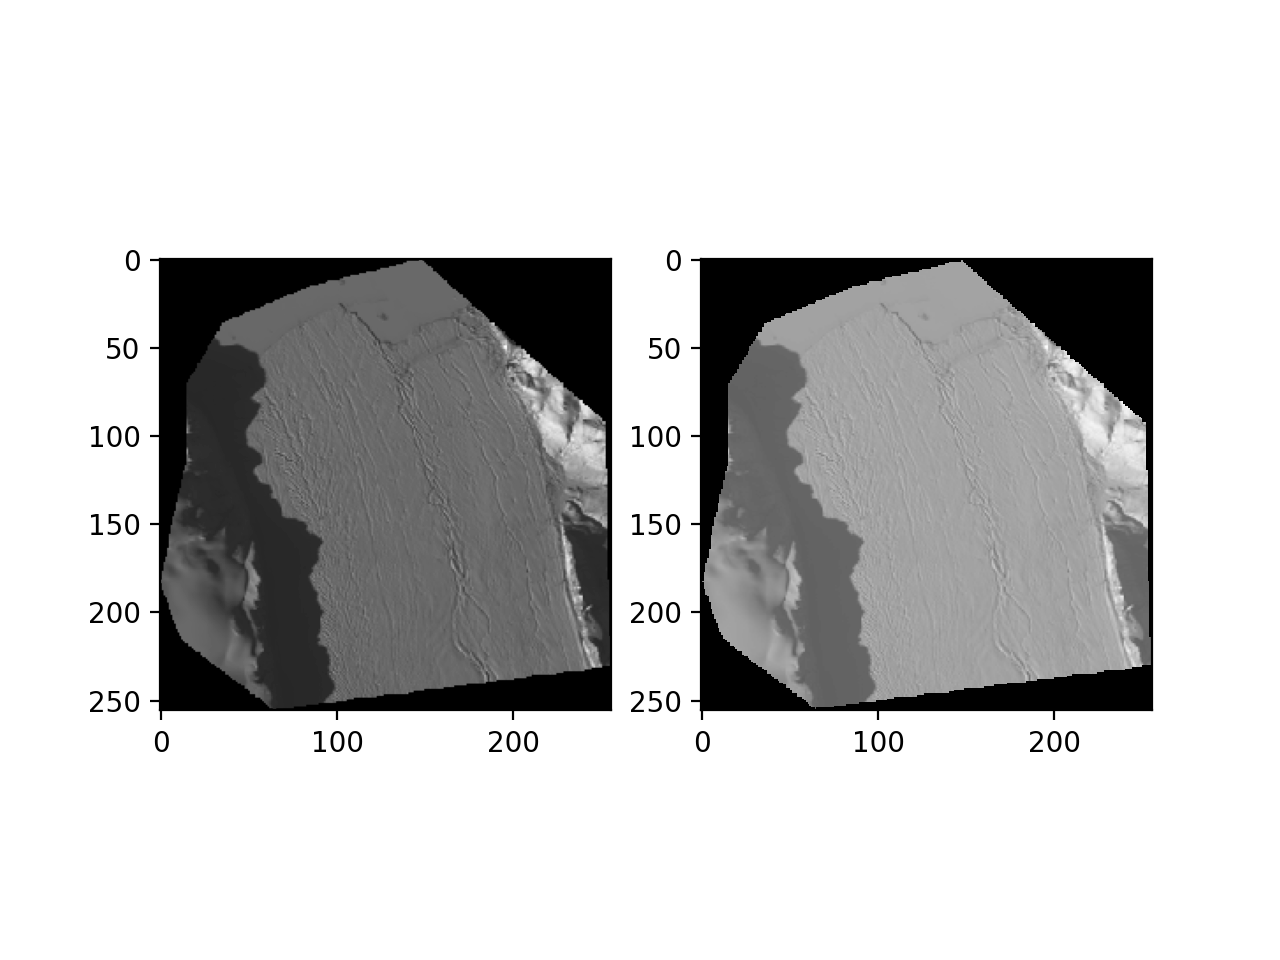

In [34]:
#Ci dessous un test pour le pseudo HDR toning, avec un code que j'ai copié sur un forum
#Plus gamma est fort et plus tu augmente la luminosité j'ai l'impression
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
#Pseudo HDR toning{{{
basename='LC08_L1TP_030247_20150420_20170228_01_T1'
img_fn=[basename+'_B1_subset.tif',basename+'_B2_subset.tif',basename+'_B3_subset.tif',basename+'_B4_subset.tif',basename+'_B5_subset.tif']
img_fn=[basename+'_B5_subset.tif']
img_list = [cv.imread(fn) for fn in img_fn]
exposure_times = np.array([255], dtype=np.float32)
#}}}
#Mergin exposures{{{
merge_debevec = cv.createMergeDebevec()
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy())
merge_robertson = cv.createMergeRobertson()
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy())
#}}}
#Tonemap HDR image{{{
tonemap1 = cv.createTonemap(gamma=2)
res_debevec = tonemap1.process(hdr_debevec.copy())
print(res_debevec.shape)
# Exposure fusion using Mertens
merge_mertens = cv.createMergeMertens()
res_mertens = merge_mertens.process(img_list)
#}}}

fig, (ax1,ax2)=plt.subplots(1,2)
ax1.imshow(raw,cmap='gray')
ax2.imshow(res_debevec)
plt.show()


In [35]:
#Le code ci-dessous est une fonction qui est censé faire du shadow highlight enhancement, aussi piqué sur le net
#Shadow highlights enhancement{{{
%matplotlib notebook
import numpy as np
import cv2

def correction(
        img,
        shadow_amount_percent, shadow_tone_percent, shadow_radius,
        highlight_amount_percent, highlight_tone_percent, highlight_radius,
        color_percent
):
    """
    Image Shadow / Highlight Correction. The same function as it in Photoshop / GIMP
    :param img: input RGB image numpy array of shape (height, width, 3)
    :param shadow_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param shadow_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param shadow_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param highlight_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param highlight_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param highlight_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param color_percent [-1.0 ~ 1.0]:
    :return:
    """
    shadow_tone = shadow_tone_percent * 255
    highlight_tone = 255 - highlight_tone_percent * 255

    shadow_gain = 1 + shadow_amount_percent * 6
    highlight_gain = 1 + highlight_amount_percent * 6

    # extract RGB channel
    height, width = img.shape[:2]
    img = img.astype(np.float)
    img_R, img_G, img_B = img[..., 2].reshape(-1), img[..., 1].reshape(-1), img[..., 0].reshape(-1)

    # The entire correction process is carried out in YUV space,
    # adjust highlights/shadows in Y space, and adjust colors in UV space
    # convert to Y channel (grey intensity) and UV channel (color)
    img_Y = .3 * img_R + .59 * img_G + .11 * img_B
    img_U = -img_R * .168736 - img_G * .331264 + img_B * .5
    img_V = img_R * .5 - img_G * .418688 - img_B * .081312

    # extract shadow / highlight
    shadow_map = 255 - img_Y * 255 / shadow_tone
    shadow_map[np.where(img_Y >= shadow_tone)] = 0
    highlight_map = 255 - (255 - img_Y) * 255 / (255 - highlight_tone)
    highlight_map[np.where(img_Y <= highlight_tone)] = 0

    # // Gaussian blur on tone map, for smoother transition
    if shadow_amount_percent * shadow_radius > 0:
        # shadow_map = cv2.GaussianBlur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius), sigmaX=0).reshape(-1)
        shadow_map = cv2.blur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius)).reshape(-1)

    if highlight_amount_percent * highlight_radius > 0:
        # highlight_map = cv2.GaussianBlur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius), sigmaX=0).reshape(-1)
        highlight_map = cv2.blur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius)).reshape(-1)

    # Tone LUT
    t = np.arange(256)
    LUT_shadow = (1 - np.power(1 - t * (1 / 255), shadow_gain)) * 255
    LUT_shadow = np.maximum(0, np.minimum(255, np.int_(LUT_shadow + .5)))
    LUT_highlight = np.power(t * (1 / 255), highlight_gain) * 255
    LUT_highlight = np.maximum(0, np.minimum(255, np.int_(LUT_highlight + .5)))

    # adjust tone
    shadow_map = shadow_map * (1 / 255)
    highlight_map = highlight_map * (1 / 255)

    iH = (1 - shadow_map) * img_Y + shadow_map * LUT_shadow[np.int_(img_Y)]
    iH = (1 - highlight_map) * iH + highlight_map * LUT_highlight[np.int_(iH)]
    img_Y = iH

    # adjust color
    if color_percent != 0:
        # color LUT
        if color_percent > 0:
            LUT = (1 - np.sqrt(np.arange(32768)) * (1 / 128)) * color_percent + 1
        else:
            LUT = np.sqrt(np.arange(32768)) * (1 / 128) * color_percent + 1

        # adjust color saturation adaptively according to highlights/shadows
        color_gain = LUT[np.int_(img_U ** 2 + img_V ** 2 + .5)]
        w = 1 - np.minimum(2 - (shadow_map + highlight_map), 1)
        img_U = w * img_U + (1 - w) * img_U * color_gain
        img_V = w * img_V + (1 - w) * img_V * color_gain

    # re convert to RGB channel
    output_R = np.int_(img_Y + 1.402 * img_V + .5)
    output_G = np.int_(img_Y - .34414 * img_U - .71414 * img_V + .5)
    output_B = np.int_(img_Y + 1.772 * img_U + .5)

    output = np.row_stack([output_B, output_G, output_R]).T.reshape(height, width, 3)
    #output = np.minimum(output, 255).astype(np.uint8)
    output = np.minimum(np.maximum(output,0), 255).astype(np.uint8) #suggested by comment
    return output
#}}}

<IPython.core.display.Javascript object>


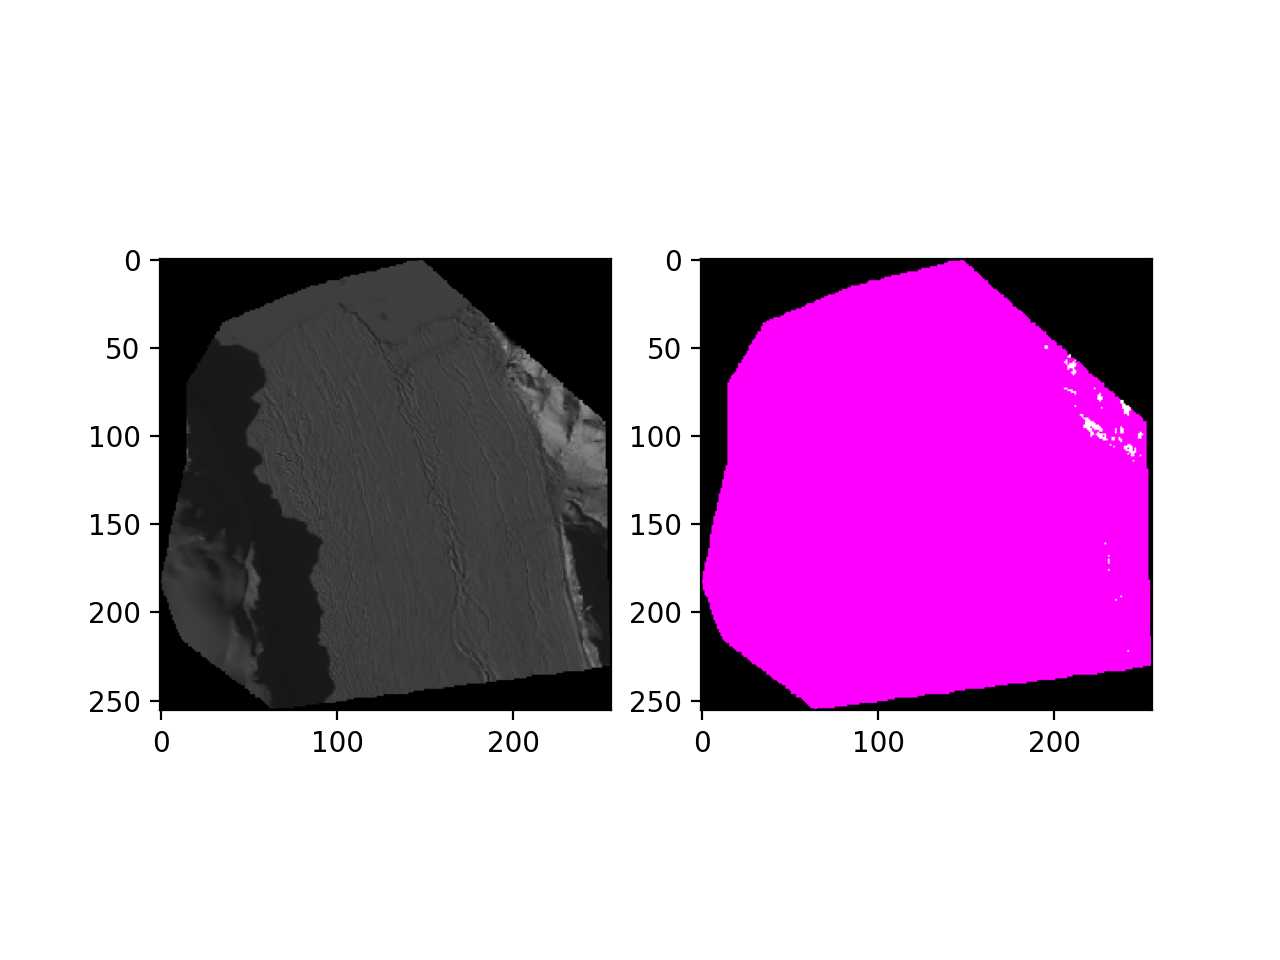

In [55]:
#Test de run de la fonction
from skimage.io import imsave, imread
basename='LC08_L1TP_030247_20150420_20170228_01_T1'
img_fn=basename+'_B5_subset.tif'
img_list = cv.imread(img_fn)
"""
Image Shadow / Highlight Correction. The same function as it in Photoshop / GIMP
:param img: input RGB image numpy array of shape (height, width, 3)
:param shadow_amount_percent [0.0 ~ 1.0]: Controls how much of a correction to make.
:param shadow_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
:param shadow_radius [>0]: Controls the size of the local neighborhood around each pixel
:param highlight_amount_percent [0.0 ~ 1.0]: Controls how much of a correction to make.
:param highlight_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
:param highlight_radius [>0]: Controls the size of the local neighborhood around each pixel
:param color_percent [-1.0 ~ 1.0]:
:return:
"""
    
output=correction(img_list,0.6,1,20,0.6,0.6,2,1)
#output=correction(img_list,0.8)
fig, (ax1,ax2) =plt.subplots(1,2)
ax1.imshow(img_list,vmin=0,vmax=150)
ax2.imshow(output,vmin=0,vmax=150)
plt.show()


In [58]:
#Le code ci-dessous est un exemple pour sauvegarder les images en png et ensuite les stacker dans une couche RGB
#Saving the three images to png
#Le point négatifs est que l'on perd les coordonnées GEO, mais celles ci sont toujours stockées dans le geotiff initial
status=cv2.imwrite('sh_enhance.png',output)#Save the shadow highlight image
status2=cv2.imwrite('hdr_proc.png',res_mertens)#Save the pseudo hdr toning image
status3=cv2.imwrite('raw_image.png',img_list) #save the raw image
print(status,status2,status3)

#Opening the three images and saving a single rgb
#L'image en sortie est chelou, les valeurs 65535, je ne sais pas trop d'où cela sort
from skimage.io import imsave, imread
import skimage
import numpngw

raw_img=imread('raw_image.png',as_gray=True)
hdr_img=imread('hdr_proc.png',as_gray=True)
sh_img=imread('sh_enhance.png',as_gray=True)

#Convert greyscale to RGB greyscale
raw_max = raw_img.max()
hdr_max = hdr_img.max()
sh_max = sh_img.max()
print(raw_max, hdr_max, sh_max, raw_img.dtype)

if (raw_img.dtype != np.uint16):
    raw_img = np.round(raw_img / raw_max * 65535.).astype(np.uint16) #np.uint16 [0, 65535]
if (hdr_img.dtype != np.uint16):
    hdr_img = np.round(hdr_img / hdr_max * 65535.).astype(np.uint16) #np.uint16 [0, 65535]
if (sh_img.dtype != np.uint16):
    sh_img = np.round(sh_img / sh_max * 65535.).astype(np.uint16) #np.uint16 [0, 65535]
    
rgb_img = np.stack((raw_img, hdr_img, sh_img), axis=-1)
rgb_img = rgb_img[:,:,::-1]
plt.imshow(rgb_img);plt.show()

save_path = '/mnt/data/millanr1/DATA_SERVER/GREENLAND/DAMAGING/CREVASSES/CALFIN/rgb_image.png'
print('Saving processed raw to:', save_path)
numpngw.write_png(save_path, rgb_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True True True
0.596078431372549 0.00392156862745098 0.8784313725490196 float64
Saving processed raw to: /mnt/data/millanr1/DATA_SERVER/GREENLAND/DAMAGING/CREVASSES/CALFIN/rgb_image.png
